In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### blip2_molt5_qformer.py

In [15]:
%%writefile blip2_molt5_qformer.py

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings; warnings.filterwarnings("ignore")

import contextlib
import logging
import os
import torch
import numpy as np
import torch.distributed as dist
import torch.nn as nn
from torch.cuda.amp import autocast as autocast
from torch.nn import functional as F
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import BertTokenizer, BertConfig, BertLMHeadModel
from typing import Dict, List, Optional, Tuple, Union

class LayerNorm(nn.LayerNorm):
    def forward(self, x: torch.Tensor, mask=None):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)

def disabled_train(self, mode=True):
    return self

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

class BlipOutput:
    def __init__(self, loss=None, logits=None, similarity=None, intermediate_output=None):
        self.loss = loss
        self.logits = logits
        self.similarity = similarity
        self.intermediate_output = intermediate_output

class BlipBaseQFormer(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @classmethod
    def init_tokenizer(cls, bert_name="bert-base-uncased"):
        tokenizer = BertTokenizer.from_pretrained(bert_name)
        tokenizer.add_special_tokens({"bos_token": "[DEC]"})
        return tokenizer

    def maybe_autocast(self, dtype=torch.float16):
        enable_autocast = self.device != torch.device("cpu")
        if enable_autocast:
            return torch.cuda.amp.autocast(dtype=dtype)
        else:
            return contextlib.nullcontext()

    @classmethod
    def init_Qformer(cls, bert_name, num_query_token, encoder_width, cross_attention_freq=2):
        encoder_config = BertConfig.from_pretrained(bert_name, is_decoder=True)
        encoder_config.encoder_width = encoder_width
        encoder_config.add_cross_attention = True
        encoder_config.cross_attention_freq = cross_attention_freq
        encoder_config.query_length = num_query_token

        Qformer = BertLMHeadModel.from_pretrained(
            bert_name, config=encoder_config
        )
        query_tokens = nn.Parameter(
            torch.zeros(1, num_query_token, encoder_config.hidden_size)
        )
        query_tokens.data.normal_(mean=0.0, std=encoder_config.initializer_range)
        return Qformer, query_tokens

    def load_from_pretrained(self, url_or_filename):
        if os.path.isfile(url_or_filename):
            checkpoint = torch.load(url_or_filename, map_location="cpu")
        else:
            raise RuntimeError("checkpoint url or path is invalid")

        state_dict = checkpoint["model"]
        msg = self.load_state_dict(state_dict, strict=False)
        logging.info("load checkpoint from %s" % url_or_filename)
        return msg

class Blip2QformerMolT5(BlipBaseQFormer):
    def __init__(
        self,
        bert_name="bert-base-uncased",
        temperature=0.05,
        freeze_molt5=True,
        molt5_model_name="laituan245/molt5-base",
        tune_qformer=True,
        num_query_token=32,
        cross_attention_freq=2,
        embed_dim=256,
    ):
        super().__init__()

        self.tokenizer = self.init_tokenizer(bert_name)
        self.molt5_tokenizer = AutoTokenizer.from_pretrained(molt5_model_name, model_max_length=512)
        self.molt5 = T5ForConditionalGeneration.from_pretrained(molt5_model_name)

        self.freeze_molt5 = freeze_molt5
        if freeze_molt5:
            for param in self.molt5.parameters():
                param.requires_grad = False
            self.molt5.eval()
            self.molt5.train = disabled_train
            logging.info("freeze MolT5 encoder and decoder")

        self.Qformer, self.query_tokens = self.init_Qformer(
            bert_name,
            num_query_token,
            self.molt5.config.d_model,
            cross_attention_freq
        )
        self.Qformer.resize_token_embeddings(len(self.tokenizer))

        state_dict = self.Qformer.state_dict()
        for name, param in self.Qformer.named_parameters():
            if "_query" in name:
                key_orig = name.replace("_query", "")
                param.data.copy_(state_dict[key_orig])

        self.cell_proj = nn.Linear(embed_dim, self.Qformer.config.hidden_size)
        self.molt5_proj = nn.Linear(self.Qformer.config.hidden_size, embed_dim)
        self.text_proj = nn.Linear(self.Qformer.config.hidden_size, embed_dim)

        if not tune_qformer:
            for name, param in self.Qformer.named_parameters():
                param.requires_grad = False
            self.Qformer.eval()
            self.Qformer.train = disabled_train
            logging.info("freeze QFormer")

        self.temperature = temperature
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def encode_molt5(self, smiles_texts):
        try:
            molt5_inputs = self.molt5_tokenizer(
                smiles_texts,
                padding=True,
                truncation=True,
                return_tensors="pt"
            ).to(self.device)

            with torch.no_grad():
                try:
                    molt5_outputs = self.molt5.encoder(
                        input_ids=molt5_inputs.input_ids,
                        attention_mask=molt5_inputs.attention_mask,
                        return_dict=True
                    )
                    molt5_embeds = molt5_outputs.last_hidden_state

                    # Check for NaNs right after model output
                    if torch.isnan(molt5_embeds).any():
                        molt5_embeds = torch.nan_to_num(molt5_embeds, nan=0.0)

                    molt5_attention_mask = molt5_inputs.attention_mask
                except Exception as e:
                    print(f"Error in MolT5 encoding: {e}")
                    # Provide fallback embeddings if there's an error
                    batch_size = len(smiles_texts)
                    dim = self.molt5.config.d_model
                    seq_len = 20  # Reasonable default
                    molt5_embeds = torch.zeros((batch_size, seq_len, dim), device=self.device)
                    molt5_attention_mask = torch.ones((batch_size, seq_len), device=self.device)
        except Exception as e:
            print(f"Error in tokenization: {e}")
            # Provide fallback embeddings
            batch_size = len(smiles_texts)
            dim = self.molt5.config.d_model
            seq_len = 20
            molt5_embeds = torch.zeros((batch_size, seq_len, dim), device=self.device)
            molt5_attention_mask = torch.ones((batch_size, seq_len), device=self.device)

        # Additional safeguard to ensure no NaNs propagate
        molt5_embeds = torch.nan_to_num(molt5_embeds, nan=0.0)

        return molt5_embeds, molt5_attention_mask

    def encode_cell(self, cell_embeddings):
        cell_embeddings = self.cell_proj(cell_embeddings)
        return cell_embeddings

    def forward(self, cell_embeddings, smiles_texts):
        # Add sequence dimension to cell embeddings
        cell_embeds = self.encode_cell(cell_embeddings)
        cell_embeds = cell_embeds.unsqueeze(1)  # Add sequence dimension [batch, 1, hidden_size]

        molt5_embeds, molt5_attention_mask = self.encode_molt5(smiles_texts)

        batch_size = cell_embeds.size(0)
        query_tokens = self.query_tokens.expand(batch_size, -1, -1)

        # Get cell features via QFormer
        query_output = self.Qformer.bert(
            inputs_embeds=query_tokens,
            attention_mask=torch.ones(query_tokens.size()[:-1], device=query_tokens.device),
            encoder_hidden_states=cell_embeds,
            encoder_attention_mask=None,
            return_dict=True,
        )
        cell_feats = self.text_proj(query_output.last_hidden_state)

        # Same fix for the molt5 part
        query_molt5_output = self.Qformer.bert(
            inputs_embeds=query_tokens,
            attention_mask=torch.ones(query_tokens.size()[:-1], device=query_tokens.device),
            encoder_hidden_states=molt5_embeds,
            encoder_attention_mask=molt5_attention_mask,
            return_dict=True,
        )
        molt5_feats = self.molt5_proj(query_molt5_output.last_hidden_state)

        # Normalize features
        cell_feats = F.normalize(cell_feats, p=2, dim=-1)
        molt5_feats = F.normalize(molt5_feats, p=2, dim=-1)

        # Features are already normalized above, no need to normalize again

        cell_feats_all = cell_feats
        molt5_feats_all = molt5_feats

        # Compute contrastive loss
        sim_c2m, sim_m2c, loss_contrastive = self.contrast_global(
            cell_feats, molt5_feats, cell_feats_all, molt5_feats_all, return_sim=True
        )

        return BlipOutput(
            loss=loss_contrastive,
            similarity={"cell2molt5": sim_c2m, "molt52cell": sim_m2c}
        )

    def contrast_global(self, features_cell, features_molt5, features_cell_all, features_molt5_all, return_sim=False):
        batch_size = features_cell.size(0)

        # Reshape features to [batch_size, hidden_dim]
        features_cell_flat = features_cell.view(batch_size, -1)
        features_molt5_flat = features_molt5.view(batch_size, -1)
        features_cell_all_flat = features_cell_all.view(batch_size, -1)
        features_molt5_all_flat = features_molt5_all.view(batch_size, -1)

        # Debug: Check for NaNs
        if torch.isnan(features_cell_flat).any():
            print("NaN detected in features_cell, replacing with zeros")
            features_cell_flat = torch.nan_to_num(features_cell_flat, nan=0.0)

        if torch.isnan(features_molt5_flat).any():
            print("NaN detected in features_molt5, replacing with zeros")
            features_molt5_flat = torch.nan_to_num(features_molt5_flat, nan=0.0)

        # Compute similarity scores for cell->molt5 and molt5->cell
        sim_c2m = torch.matmul(features_cell_flat, features_molt5_all_flat.transpose(0, 1))
        sim_m2c = torch.matmul(features_molt5_flat, features_cell_all_flat.transpose(0, 1))

        # Debug: Check similarity matrices
        if torch.isnan(sim_c2m).any() or torch.isnan(sim_m2c).any():
            print("NaN detected in similarity matrices, using fallback")
            # Create placeholder similarity matrices
            sim_c2m = torch.ones((batch_size, batch_size), device=features_cell.device) / batch_size
            sim_m2c = torch.ones((batch_size, batch_size), device=features_cell.device) / batch_size
            if return_sim:
                return sim_c2m, sim_m2c, torch.tensor(0.0, device=features_cell.device)
            else:
                return torch.tensor(0.0, device=features_cell.device)

        # Scale by temperature (with additional safeguard)
        temp = max(self.temperature, 1e-8)  # Prevent division by zero
        logits_c2m = sim_c2m / temp
        logits_m2c = sim_m2c / temp

        # Create labels
        labels = torch.arange(batch_size, device=self.device)

        # Compute loss with safeguards
        try:
            loss_c2m = F.cross_entropy(logits_c2m, labels)
            loss_m2c = F.cross_entropy(logits_m2c, labels)
            loss = (loss_c2m + loss_m2c) / 2
        except Exception as e:
            print(f"Error in cross entropy: {e}")
            print(f"logits_c2m shape: {logits_c2m.shape}, min: {logits_c2m.min().item()}, max: {logits_c2m.max().item()}")
            print(f"logits_m2c shape: {logits_m2c.shape}, min: {logits_m2c.min().item()}, max: {logits_m2c.max().item()}")
            print(f"labels shape: {labels.shape}, values: {labels}")
            loss = torch.tensor(0.0, device=features_cell.device)

        if return_sim:
            return sim_c2m, sim_m2c, loss
        else:
            return loss

    def predict_similarity(self, cell_embedding, smiles_text):
        """
        Calculate similarity between cell embedding and SMILES strings.

        Args:
            cell_embedding: Tensor of shape [dim] or [batch_size, dim]
            smiles_text: String or list of strings

        Returns:
            List of similarity scores
        """
        # Handle different input shapes
        if cell_embedding.dim() == 1:
            cell_embedding = cell_embedding.unsqueeze(0)

        # Convert single string to list
        if isinstance(smiles_text, str):
            smiles_text = [smiles_text]

        # Add sequence dimension to cell embeddings
        cell_embeds = self.encode_cell(cell_embedding)
        cell_embeds = cell_embeds.unsqueeze(1)  # Add sequence dimension [batch, 1, hidden_size]

        # Safe encoding of SMILES
        molt5_embeds, molt5_attention_mask = self.encode_molt5(smiles_text)

        batch_size = cell_embeds.size(0)
        query_tokens = self.query_tokens.expand(batch_size, -1, -1)

        # Get cell features via QFormer
        with torch.no_grad():
            query_output = self.Qformer.bert(
                inputs_embeds=query_tokens,
                attention_mask=torch.ones(query_tokens.size()[:-1], device=query_tokens.device),
                encoder_hidden_states=cell_embeds,
                encoder_attention_mask=None,
                return_dict=True,
            )
            cell_feats = self.text_proj(query_output.last_hidden_state)

            # Process SMILES features
            query_molt5_output = self.Qformer.bert(
                inputs_embeds=query_tokens,
                attention_mask=torch.ones(query_tokens.size()[:-1], device=query_tokens.device),
                encoder_hidden_states=molt5_embeds,
                encoder_attention_mask=molt5_attention_mask,
                return_dict=True,
            )
            molt5_feats = self.molt5_proj(query_molt5_output.last_hidden_state)

            # Normalize features
            cell_feats = F.normalize(cell_feats, p=2, dim=-1)
            molt5_feats = F.normalize(molt5_feats, p=2, dim=-1)

            # Compute similarity for each query token and average
            similarity = torch.bmm(
                cell_feats,  # [batch_size, num_query_tokens, embed_dim]
                molt5_feats.transpose(1, 2)  # [batch_size, embed_dim, num_query_tokens]
            )  # [batch_size, num_query_tokens, num_query_tokens]

            # Average over query tokens
            similarity = similarity.mean(dim=[1, 2])

            # Handle any NaN values
            similarity = torch.nan_to_num(similarity, nan=0.0)

        return similarity.cpu().tolist()

Overwriting blip2_molt5_qformer.py


#### training_script.py

In [16]:
%%writefile training_script.py

import os
import torch
import argparse
import numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

class CellMolDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        # Handle both dictionary format and CellSMILESPair format
        if isinstance(pair, dict):
            cell_embedding = pair["embedding"]
            smiles_text = pair["smiles"]
        else:
            cell_embedding = pair.cell_embedding
            smiles_text = pair.smiles

        # Ensure cell_embedding is a tensor of floats
        if isinstance(cell_embedding, str):
            print(f"Warning: Found string in cell_embedding at index {idx}")
            # Provide a fallback embedding
            return {
                "cell_embedding": torch.zeros(512, dtype=torch.float32),
                "smiles_text": smiles_text
            }

        # Convert numpy arrays to tensors if needed
        if isinstance(cell_embedding, np.ndarray):
            cell_embedding = torch.tensor(cell_embedding, dtype=torch.float32)

        return {
            "cell_embedding": cell_embedding,
            "smiles_text": smiles_text
        }

def custom_collate(batch):
    # Filter out any samples with invalid data types
    valid_batch = []
    for item in batch:
        if torch.is_tensor(item["cell_embedding"]) and isinstance(item["smiles_text"], str):
            valid_batch.append(item)
        else:
            print(f"Skipping invalid item: {type(item['cell_embedding'])}, {type(item['smiles_text'])}")

    if not valid_batch:
        # Provide a minimal valid batch
        return {
            "cell_embedding": torch.zeros((1, 512), dtype=torch.float32),
            "smiles_text": ["C"]  # Simplest SMILES string
        }

    # Standard collation for valid items
    cell_embeddings = torch.stack([item["cell_embedding"] for item in valid_batch])
    smiles_texts = [item["smiles_text"] for item in valid_batch]

    return {
        "cell_embedding": cell_embeddings,
        "smiles_text": smiles_texts
    }

def load_processed_data(input_path):
    print(f"Loading data from {input_path}")
    with open(input_path, 'rb') as f:
        pairs = pickle.load(f)
    print(f"Loaded {len(pairs)} pairs")
    return pairs

def create_datasets_from_processed_data(processed_data_dir):
    train_pairs = load_processed_data(os.path.join(processed_data_dir, "train_pairs.pkl"))
    val_pairs = load_processed_data(os.path.join(processed_data_dir, "val_pairs.pkl"))
    test_pairs = load_processed_data(os.path.join(processed_data_dir, "test_pairs.pkl"))

    train_dataset = CellMolDataset(train_pairs)
    val_dataset = CellMolDataset(val_pairs)
    test_dataset = CellMolDataset(test_pairs)

    return train_dataset, val_dataset, test_dataset

def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32, num_workers=4):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate
    )

    return train_loader, val_loader, test_loader

def parse_args():
    parser = argparse.ArgumentParser(description="Train BLIP2-MolT5-QFormer model")
    parser.add_argument("--processed_data_dir", type=str, default="processed_data", help="Directory containing the processed data pickle files")
    parser.add_argument("--bert_name", type=str, default="bert-base-uncased", help="BERT model name for QFormer")
    parser.add_argument("--molt5_model", type=str, default="laituan245/molt5-base", help="MolT5 model name")
    parser.add_argument("--embedding_dim", type=int, default=512, help="Cell embedding dimension")
    parser.add_argument("--num_query_token", type=int, default=32, help="Number of query tokens for QFormer")
    parser.add_argument("--cross_attention_freq", type=int, default=2, help="Cross attention frequency")
    parser.add_argument("--temperature", type=float, default=0.05, help="Temperature for contrastive loss")
    parser.add_argument("--freeze_molt5", action="store_true", help="Freeze MolT5 parameters")
    parser.add_argument("--tune_qformer", action="store_true", help="Tune QFormer parameters")
    parser.add_argument("--batch_size", type=int, default=8, help="Batch size")
    parser.add_argument("--num_epochs", type=int, default=20, help="Number of training epochs")
    parser.add_argument("--learning_rate", type=float, default=1e-5, help="Learning rate")
    parser.add_argument("--weight_decay", type=float, default=0.02, help="Weight decay")
    parser.add_argument("--warmup_steps", type=int, default=100, help="Warmup steps")
    parser.add_argument("--checkpoint_dir", type=str, default="checkpoints", help="Directory for checkpoints")
    parser.add_argument("--checkpoint_interval", type=int, default=1, help="Checkpoint interval in epochs")
    parser.add_argument("--eval_only", action="store_true", help="Run evaluation only")
    parser.add_argument("--eval_checkpoint", type=str, default=None, help="Checkpoint to use for evaluation")
    parser.add_argument("--seed", type=int, default=42, help="Random seed")
    parser.add_argument("--num_workers", type=int, default=4, help="Number of dataloader workers")
    return parser.parse_args()

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def plot_training_curves(train_losses, val_losses, checkpoint_dir):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(checkpoint_dir, 'training_curves.png'))
    plt.close()

def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in test_loader:
            cell_embeddings = batch["cell_embedding"].to(device)
            smiles_texts = batch["smiles_text"]

            valid_indices = [i for i, s in enumerate(smiles_texts) if isinstance(s, str)]
            if len(valid_indices) < 2:
                continue

            cell_embeddings = cell_embeddings[valid_indices]
            smiles_texts = [smiles_texts[i] for i in valid_indices]

            if torch.isnan(cell_embeddings).any():
                cell_embeddings = torch.nan_to_num(cell_embeddings, nan=0.0)

            output = model(cell_embeddings, smiles_texts)
            loss = output.loss

            if not torch.isnan(loss):
                total_loss += loss.item()
                num_batches += 1

    if num_batches == 0:
        return float('inf')

    avg_loss = total_loss / num_batches
    return avg_loss

def calculate_retrieval_metrics(model, test_dataset, k_values=(1, 5, 10), device=None):
    if device is None:
        device = next(model.parameters()).device

    model.eval()

    cell_embeddings = []
    smiles_texts = []

    # Extract data from dataset
    for i in range(len(test_dataset)):
        item = test_dataset[i]
        cell_embedding = item["cell_embedding"]
        smiles_text = item["smiles_text"]

        if isinstance(smiles_text, str):
            cell_embeddings.append(cell_embedding)
            smiles_texts.append(smiles_text)

    if len(cell_embeddings) == 0:
        print("No valid test samples found for retrieval metrics")
        return {f"R@{k}": 0.0 for k in k_values}

    metrics = {f"R@{k}": 0.0 for k in k_values}
    metrics["MRR"] = 0.0

    n_samples = len(cell_embeddings)

    for i in range(n_samples):
        query_embedding = cell_embeddings[i].to(device)
        query_smiles = smiles_texts[i]

        batch_size = 32
        all_scores = []

        for j in range(0, n_samples, batch_size):
            batch_smiles = smiles_texts[j:j+batch_size]
            batch_scores = model.predict_similarity(query_embedding, batch_smiles)
            all_scores.extend(batch_scores)

        all_scores = torch.tensor(all_scores)
        sorted_indices = torch.argsort(all_scores, descending=True)

        # Find positions where the correct SMILES appears
        target_position = -1
        for pos, idx in enumerate(sorted_indices):
            if smiles_texts[idx] == query_smiles and idx != i:
                target_position = pos
                break

        if target_position == -1:
            # If no match found, continue to next sample
            continue

        rank = target_position + 1  # +1 as ranks start from 1
        metrics["MRR"] += 1.0 / rank

        for k in k_values:
            if rank <= k:
                metrics[f"R@{k}"] += 1.0

    for metric in metrics:
        metrics[metric] /= n_samples

    return metrics

def main():
    """Main function to run training or evaluation"""
    args = parse_args()
    set_seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_dataset, val_dataset, test_dataset = create_datasets_from_processed_data(args.processed_data_dir)

    train_loader, val_loader, test_loader = create_dataloaders(
        train_dataset, val_dataset, test_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers
    )

    from blip2_molt5_qformer import Blip2QformerMolT5

    if not args.eval_only:
        model = Blip2QformerMolT5(
            bert_name=args.bert_name,
            temperature=args.temperature,
            freeze_molt5=args.freeze_molt5,
            molt5_model_name=args.molt5_model,
            tune_qformer=args.tune_qformer,
            num_query_token=args.num_query_token,
            cross_attention_freq=args.cross_attention_freq,
            embed_dim=args.embedding_dim
        ).to(device)

        # Count trainable params in MolT5
        molt5_trainable = sum(p.numel() for p in model.molt5.parameters() if p.requires_grad)
        molt5_total = sum(p.numel() for p in model.molt5.parameters())

        print(f"MolT5 trainable params: {molt5_trainable:,} / {molt5_total:,}")


        optimizer = torch.optim.AdamW(
            [p for p in model.parameters() if p.requires_grad],
            lr=args.learning_rate,
            weight_decay=args.weight_decay
        )

        total_steps = len(train_loader) * args.num_epochs
        warmup_steps = min(args.warmup_steps, total_steps // 10)

        from torch.optim.lr_scheduler import LambdaLR

        def lr_lambda(current_step):
            if current_step < warmup_steps:
                return float(current_step) / float(max(1, warmup_steps))
            return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps)))

        scheduler = LambdaLR(optimizer, lr_lambda)

        os.makedirs(args.checkpoint_dir, exist_ok=True)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')

        for epoch in range(args.num_epochs):
            print(f"Epoch {epoch+1}/{args.num_epochs}")
            model.train()
            train_loss = 0.0
            valid_batches = 0

            for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}")):
                cell_embeddings = batch["cell_embedding"].to(device)
                smiles_texts = batch["smiles_text"]

                valid_indices = [i for i, s in enumerate(smiles_texts) if isinstance(s, str)]
                if len(valid_indices) < 2:
                    print(f"Skipping batch {batch_idx}: not enough valid SMILES")
                    continue

                cell_embeddings = cell_embeddings[valid_indices]
                smiles_texts = [smiles_texts[i] for i in valid_indices]

                if torch.isnan(cell_embeddings).any():
                    cell_embeddings = torch.nan_to_num(cell_embeddings, nan=0.0)

                optimizer.zero_grad()

                output = model(cell_embeddings, smiles_texts)
                loss = output.loss

                if not torch.isnan(loss):
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    scheduler.step()

                    train_loss += loss.item()
                    valid_batches += 1
                else:
                    print(f"Warning: NaN loss in batch {batch_idx}, skipping")

            # Calculate average training loss
            avg_train_loss = train_loss / valid_batches if valid_batches > 0 else float('inf')
            train_losses.append(avg_train_loss)
            print(f"Train Loss: {avg_train_loss:.6f}")

            # Validation
            val_loss = evaluate_model(model, val_loader, device)
            val_losses.append(val_loss)
            print(f"Validation Loss: {val_loss:.6f}")

            # Save model if it's the best so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "train_loss": avg_train_loss,
                    "val_loss": val_loss
                }, os.path.join(args.checkpoint_dir, "best_model.pth"))
                print(f"Saved new best model with validation loss: {val_loss:.6f}")

            # Regular checkpoint saving
            if (epoch + 1) % args.checkpoint_interval == 0:
                torch.save({
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "train_loss": avg_train_loss,
                    "val_loss": val_loss
                }, os.path.join(args.checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth"))

        # Plot and save learning curves
        plot_training_curves(train_losses, val_losses, args.checkpoint_dir)

        # Save final model
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": args.num_epochs - 1,
            "train_loss": train_losses[-1],
            "val_loss": val_losses[-1]
        }, os.path.join(args.checkpoint_dir, "final_model.pth"))

        # Final evaluation
        print("Evaluating on test set...")
        test_loss = evaluate_model(model, test_loader, device)
        print(f"Test Loss: {test_loss:.6f}")

        # Calculate retrieval metrics
        print("Calculating retrieval metrics...")
        retrieval_metrics = calculate_retrieval_metrics(model, test_dataset, device=device)
        for metric, value in retrieval_metrics.items():
            print(f"{metric}: {value:.4f}")
    else:
        # Evaluation only mode
        if args.eval_checkpoint is None:
            args.eval_checkpoint = os.path.join(args.checkpoint_dir, "best_model.pth")
            if not os.path.exists(args.eval_checkpoint):
                raise ValueError(f"No checkpoint found at {args.eval_checkpoint}")

        print(f"Loading model from {args.eval_checkpoint} for evaluation")
        model = Blip2QformerMolT5(
            bert_name=args.bert_name,
            temperature=args.temperature,
            freeze_molt5=args.freeze_molt5,
            molt5_model_name=args.molt5_model,
            tune_qformer=args.tune_qformer,
            num_query_token=args.num_query_token,
            cross_attention_freq=args.cross_attention_freq,
            embed_dim=args.embedding_dim
        ).to(device)

        checkpoint = torch.load(args.eval_checkpoint, map_location=device)
        model.load_state_dict(checkpoint["model"])

        print("Evaluating on test set...")
        test_loss = evaluate_model(model, test_loader, device)
        print(f"Test Loss: {test_loss:.6f}")

        print("Calculating retrieval metrics...")
        retrieval_metrics = calculate_retrieval_metrics(model, test_dataset, device=device)
        for metric, value in retrieval_metrics.items():
            print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()

Overwriting training_script.py


#### run script

In [17]:
# Directory paths
PROCESSED_DATA_DIR="/content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/"
CHECKPOINT_DIR="/content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/checkpoints_qformer2"

# Model parameters
BERT_NAME="bert-base-uncased"
MOLT5_MODEL="laituan245/molt5-base"
EMBEDDING_DIM=512
NUM_QUERY_TOKEN=32
TEMPERATURE=0.05

# Training parameters
BATCH_SIZE=8
NUM_EPOCHS=20
LEARNING_RATE=1e-5
WEIGHT_DECAY=0.02
NUM_WORKERS=2

# Create checkpoint directory if it doesn't exist
!mkdir -p "{CHECKPOINT_DIR}"

# Run training using %run magic
%run training_script.py --processed_data_dir="{PROCESSED_DATA_DIR}" --checkpoint_dir="{CHECKPOINT_DIR}" --bert_name={BERT_NAME} --molt5_model={MOLT5_MODEL} --embedding_dim={EMBEDDING_DIM} --num_query_token={NUM_QUERY_TOKEN} --temperature={TEMPERATURE} --batch_size={BATCH_SIZE} --num_epochs={NUM_EPOCHS} --learning_rate={LEARNING_RATE} --weight_decay={WEIGHT_DECAY} --num_workers={NUM_WORKERS} --tune_qformer

Using device: cuda
Loading data from /content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/train_pairs.pkl
Loaded 42712 pairs
Loading data from /content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/val_pairs.pkl
Loaded 9121 pairs
Loading data from /content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/test_pairs.pkl
Loaded 7581 pairs


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

MolT5 trainable params: 247,577,856 / 247,577,856
Epoch 1/20


Training epoch 1: 100%|██████████| 5339/5339 [20:13<00:00,  4.40it/s]

Train Loss: 2.373980


Validation Loss: 2.079448
Saved new best model with validation loss: 2.079448
Epoch 2/20


Training epoch 2: 100%|██████████| 5339/5339 [20:40<00:00,  4.30it/s]

Train Loss: 2.082982


Validation Loss: 2.079445
Saved new best model with validation loss: 2.079445
Epoch 3/20


Training epoch 3: 100%|██████████| 5339/5339 [20:32<00:00,  4.33it/s]

Train Loss: 2.081505


Validation Loss: 2.079443
Saved new best model with validation loss: 2.079443
Epoch 4/20


Training epoch 4: 100%|██████████| 5339/5339 [20:45<00:00,  4.29it/s]

Train Loss: 2.080997


Validation Loss: 2.079441
Saved new best model with validation loss: 2.079441
Epoch 5/20


Training epoch 5: 100%|██████████| 5339/5339 [20:38<00:00,  4.31it/s]

Train Loss: 2.080643


Validation Loss: 2.079436
Saved new best model with validation loss: 2.079436
Epoch 6/20


Training epoch 6: 100%|██████████| 5339/5339 [20:39<00:00,  4.31it/s]

Train Loss: 2.080313


Validation Loss: 2.079429
Saved new best model with validation loss: 2.079429
Epoch 7/20


Training epoch 7: 100%|██████████| 5339/5339 [20:40<00:00,  4.30it/s]

Train Loss: 2.080225


Validation Loss: 2.079398
Saved new best model with validation loss: 2.079398
Epoch 8/20


Training epoch 8: 100%|██████████| 5339/5339 [20:42<00:00,  4.30it/s]

Train Loss: 2.078585


Validation Loss: 2.080753
Epoch 9/20


Training epoch 9: 100%|██████████| 5339/5339 [20:28<00:00,  4.35it/s]

Train Loss: 2.073321


Validation Loss: 2.091867
Epoch 10/20


Training epoch 10: 100%|██████████| 5339/5339 [20:28<00:00,  4.35it/s]

Train Loss: 2.069672


Validation Loss: 2.092642
Epoch 11/20


Training epoch 11: 100%|██████████| 5339/5339 [20:30<00:00,  4.34it/s]

Train Loss: 2.065363


Validation Loss: 2.098831
Epoch 12/20


Training epoch 12: 100%|██████████| 5339/5339 [20:31<00:00,  4.34it/s]

Train Loss: 2.060978


Validation Loss: 2.091729
Epoch 13/20


Training epoch 13: 100%|██████████| 5339/5339 [20:30<00:00,  4.34it/s]

Train Loss: 2.052467


Validation Loss: 2.096652
Epoch 14/20


Training epoch 14: 100%|██████████| 5339/5339 [20:30<00:00,  4.34it/s]

Train Loss: 2.042696


Validation Loss: 2.131662
Epoch 15/20


Training epoch 15: 100%|██████████| 5339/5339 [20:31<00:00,  4.33it/s]

Train Loss: 2.039319


Validation Loss: 2.136109
Epoch 16/20


Training epoch 16: 100%|██████████| 5339/5339 [20:38<00:00,  4.31it/s]

Train Loss: 2.034238


Validation Loss: 2.129242
Epoch 17/20


Training epoch 17: 100%|██████████| 5339/5339 [20:32<00:00,  4.33it/s]

Train Loss: 2.029588


Validation Loss: 2.121138
Epoch 18/20


Training epoch 18: 100%|██████████| 5339/5339 [20:40<00:00,  4.31it/s]

Train Loss: 2.026394


Validation Loss: 2.123940
Epoch 19/20


Training epoch 19: 100%|██████████| 5339/5339 [20:40<00:00,  4.30it/s]

Train Loss: 2.024288


Validation Loss: 2.126295
Epoch 20/20


Training epoch 20: 100%|██████████| 5339/5339 [20:45<00:00,  4.29it/s]

Train Loss: 2.021309


Validation Loss: 2.135240
Evaluating on test set...
Test Loss: 2.154565
Calculating retrieval metrics...


RuntimeError: shape '[1, 32, 768]' is invalid for input of size 786432

<Figure size 640x480 with 0 Axes>

#### reload best checkpoint

In [5]:
import torch
from blip2_molt5_qformer import Blip2QformerMolT5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Match your training flags
model = Blip2QformerMolT5(
    bert_name="bert-base-uncased",
    temperature=0.05,
    freeze_molt5=True,
    molt5_model_name="laituan245/molt5-base",
    tune_qformer=True,
    num_query_token=32,
    cross_attention_freq=2,
    embed_dim=512
).to(device)

# Load best checkpoint
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/checkpoints/best_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model weights
model.load_state_dict(checkpoint["model"])

# Confirm load
print(f"✅ Loaded best checkpoint from epoch {checkpoint['epoch'] + 1}")
print(f"   Train loss: {checkpoint['train_loss']:.6f}")
print(f"   Val loss:   {checkpoint['val_loss']:.6f}")


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

✅ Loaded best checkpoint from epoch 2
   Train loss: 2.082658
   Val loss:   2.079445


#### sanity checks qformer works or not

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

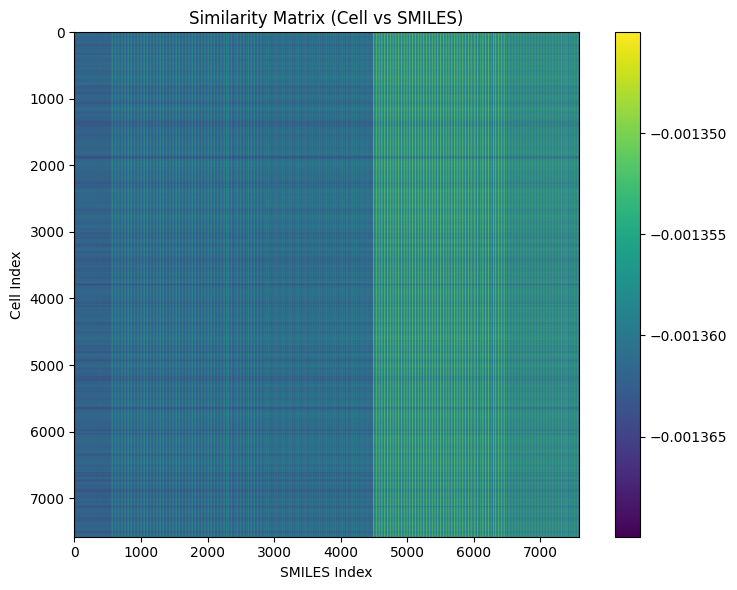

In [9]:
import torch
import matplotlib.pyplot as plt
import pickle
from blip2_molt5_qformer import Blip2QformerMolT5
from training_script import CellMolDataset, custom_collate
from torch.utils.data import DataLoader

# Paths
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/checkpoints_qformer/best_model.pth"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/codebasev2/run1_codes/test_pairs.pkl"

# Load data
with open(test_data_path, "rb") as f:
    test_pairs = pickle.load(f)
test_dataset = CellMolDataset(test_pairs)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Blip2QformerMolT5(
    bert_name="bert-base-uncased",
    temperature=0.05,
    freeze_molt5=True,
    molt5_model_name="laituan245/molt5-base",
    tune_qformer=True,
    num_query_token=32,
    cross_attention_freq=2,
    embed_dim=512
).to(device)

model.load_state_dict(torch.load(checkpoint_path, map_location=device)["model"])
model.eval()

# Store features
cell_feats_all, smiles_feats_all = [], []

with torch.no_grad():
    for batch in test_loader:
        cell = batch["cell_embedding"].to(device)
        smiles = batch["smiles_text"]

        # Encode with QFormer only
        cell_feats = model.text_proj(
            model.Qformer.bert(
                inputs_embeds=model.query_tokens.expand(cell.size(0), -1, -1),
                attention_mask=torch.ones(cell.size(0), model.query_tokens.size(1)).to(device),
                encoder_hidden_states=model.encode_cell(cell).unsqueeze(1),
                encoder_attention_mask=None,
                return_dict=True
            ).last_hidden_state
        )

        smiles_embeds, smiles_mask = model.encode_molt5(smiles)
        smiles_feats = model.molt5_proj(
            model.Qformer.bert(
                inputs_embeds=model.query_tokens.expand(cell.size(0), -1, -1),
                attention_mask=torch.ones(cell.size(0), model.query_tokens.size(1)).to(device),
                encoder_hidden_states=smiles_embeds,
                encoder_attention_mask=smiles_mask,
                return_dict=True
            ).last_hidden_state
        )

        # Normalize
        cell_feats = torch.nn.functional.normalize(cell_feats.mean(dim=1), dim=-1)
        smiles_feats = torch.nn.functional.normalize(smiles_feats.mean(dim=1), dim=-1)

        cell_feats_all.append(cell_feats)
        smiles_feats_all.append(smiles_feats)

# Stack and compute similarity matrix
cell_mat = torch.cat(cell_feats_all, dim=0)
smiles_mat = torch.cat(smiles_feats_all, dim=0)
sim_matrix = torch.matmul(cell_mat, smiles_mat.T).cpu().numpy()

# Plot similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(sim_matrix, cmap="viridis")
plt.colorbar()
plt.title("Similarity Matrix (Cell vs SMILES)")
plt.xlabel("SMILES Index")
plt.ylabel("Cell Index")
plt.tight_layout()
plt.show()
